# Hospitalization Data

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler, moving_average 

## Functions

In [2]:
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

def model_daily(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += deriv_f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += deriv_f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta >= 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 


## Main code

In [3]:
# Increase font-size
plt.rcParams.update({'font.size': 14})

# Import data
data = pd.read_csv("Datasets/rosario_hosp.csv") 
city_name = 'Rosario' 

acc_data = data.cumulative_hospitalized_patients
normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()
daily_data = data.new_hospitalized_patients.tolist()

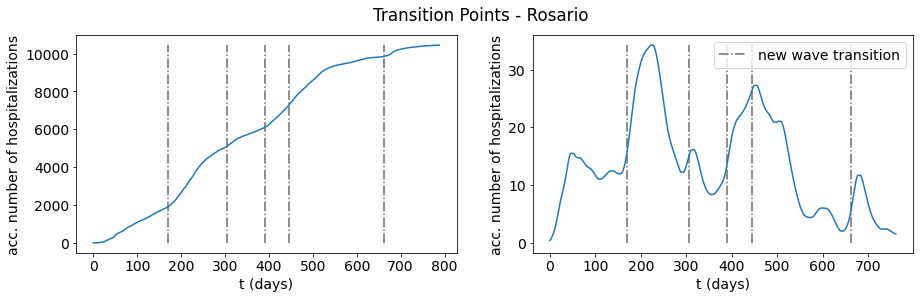

In [4]:
# Transition Points - Hospitalization

if city_name == 'Rosario':
    #x_nw = [166, 226, 303, 375, 431, 590, 657] 
    x_nw = [169, 305, 390, 445, 662]# Rosario 2e-5
elif city_name == 'Buenos Aires':
    x_nw = [326, 405, 687] #Buenos Aires 1e-5
elif city_name == 'Mendoza':
    x_nw = [315, 400, 510] # Manual Mendoza
elif city_name == 'Córdoba':
    x_nw = [300, 400, 520] # Manual Córdoba
else:
    x_nw = [300, 400, 520] 
    
fig, axs = plt.subplots(1, 2, figsize=(15,4))
plt.suptitle(f'Transition Points - {city_name}')
axs[0].vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[0].plot(acc_data)
axs[0].set_xlabel('t (days)')
axs[0].set_ylabel('acc. number of hospitalizations')
axs[1].vlines(x_nw, 0, max(filter_data(daily_data)), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[1].plot(filter_data(daily_data))
axs[1].set_xlabel('t (days)')
axs[1].set_ylabel('acc. number of hospitalizations')
plt.legend()
plt.savefig(f'HOSP/TP_{city_name}', facecolor='white', dpi=100)
plt.show()

### Predictions (Cumulative + Daily)

========= Wave nr 1 =========
From 0 to  155
Step 1
     fun: 3470.483746662757
     jac: array([-9.15527344e-05,  4.63867188e-03,  1.61743164e-03,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 151
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.7089764e+03, 8.4020490e+01, 2.5701900e+01, 1.0000000e+00])
Step 2
     fun: 1361.0962680197993
     jac: array([7.62939453e-05, 1.61743164e-03, 3.50952148e-04, 2.11926656e+03])
 message: 'Optimization terminated successfully'
    nfev: 85
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.94848104e+03, 7.63269787e+01, 4.42441893e+01, 1.00000000e-01])


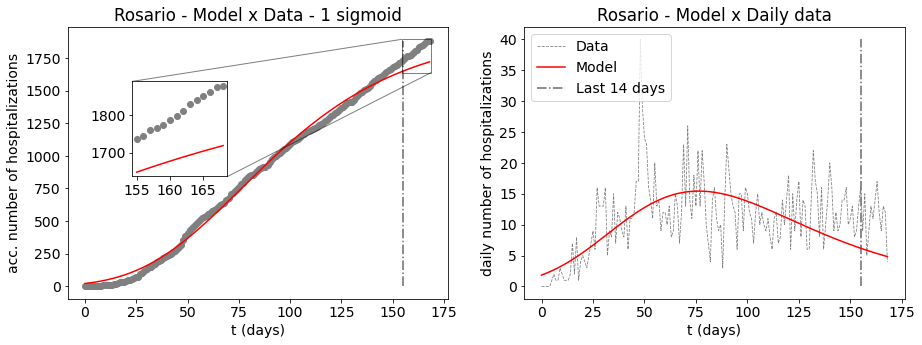

Parameters: [[1948.4810445238204, 76.32697872346891, 44.24418932125283, 0.10000000000002086]]
========= Wave nr 2 =========
From 0 to  291
Step 1
     fun: 1589.9022590204984
     jac: array([4.57763672e-05, 2.44140625e-04, 1.06811523e-03, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([3.03909978e+03, 2.22736399e+02, 2.11454862e+01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 722.1569430790121
     jac: array([ 9.15527344e-05,  2.15911865e-03, -6.75201416e-03, -9.74273682e-02])
 message: 'Optimization terminated successfully'
    nfev: 101
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([3.34175793e+03, 2.17365872e+02, 3.31609742e+01, 2.44211829e-01])


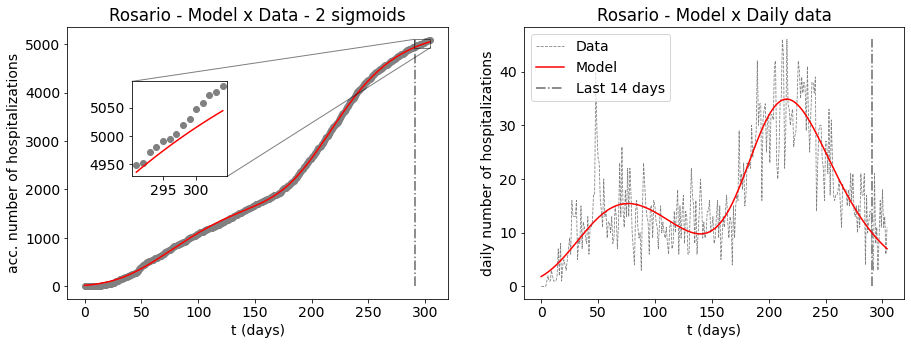

Parameters: [[1948.4810445238204, 76.32697872346891, 44.24418932125283, 0.10000000000002086], [3341.7579335398245, 217.36587165105263, 33.16097417129669, 0.24421182866325875]]
========= Wave nr 3 =========
From 0 to  376
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 747.9407179768323
     jac: array([-0.00019073, -0.0013504 ,  0.00559998,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 204
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([627.31301698, 328.771239  ,  12.97491674,   1.        ])
Step 2
     fun: 639.5496442512581
     jac: array([-1.37329102e-04,  1.31988525e-03,  1.78527832e-03,  9.60143509e+01])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([6.89216088e+02, 3.23823155e+02, 2.14892862e+01, 1.00000000e-01])


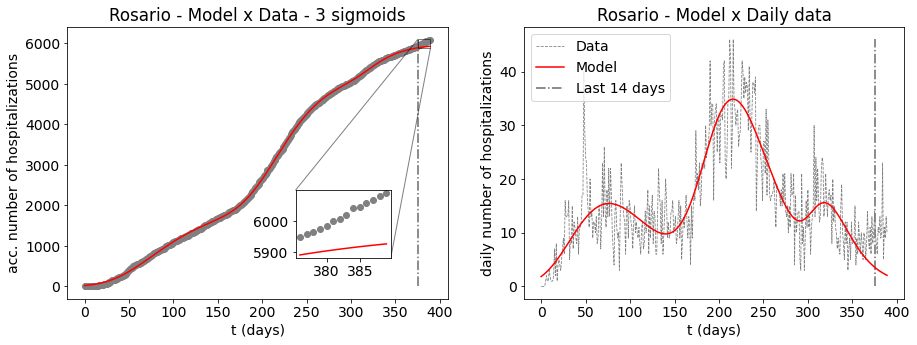

Parameters: [[1948.4810445238204, 76.32697872346891, 44.24418932125283, 0.10000000000002086], [3341.7579335398245, 217.36587165105263, 33.16097417129669, 0.24421182866325875], [689.2160882402919, 323.8231553153267, 21.489286236248045, 0.10000000000000338]]
========= Wave nr 4 =========
From 0 to  431
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 583.966090745978
     jac: array([ 3.81469727e-05, -1.22070312e-04,  9.15527344e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 112
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([1.11183117e+03, 4.11989149e+02, 1.22511673e+01, 1.00000000e+00])
Step 2
     fun: 556.1305104699691
     jac: array([ 1.52587891e-05,  8.39233398e-05, -1.67083740e-03,  1.80447998e+01])
 message: 'Optimization terminated successfully'
    nfev: 173
     nit: 33
    njev: 33
  status: 0
 success: True
       x: array([1.73649729e+03, 4.17651213e+02, 2.84408790e+01, 1.00000000e-01])


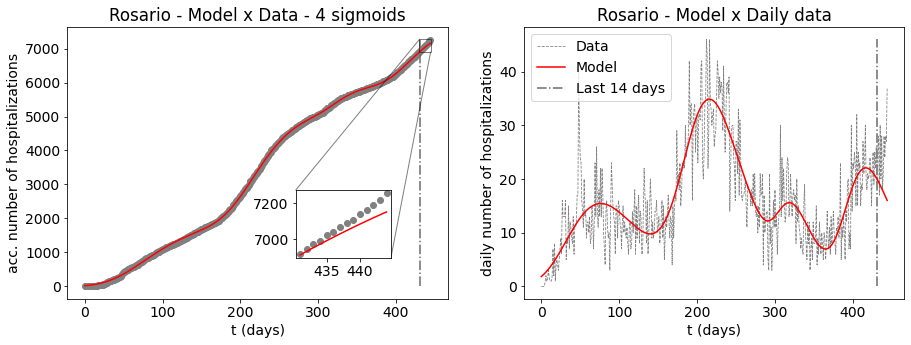

Parameters: [[1948.4810445238204, 76.32697872346891, 44.24418932125283, 0.10000000000002086], [3341.7579335398245, 217.36587165105263, 33.16097417129669, 0.24421182866325875], [689.2160882402919, 323.8231553153267, 21.489286236248045, 0.10000000000000338], [1736.497286425565, 417.651212578082, 28.4408789687567, 0.10000000000000003]]
========= Wave nr 5 =========
From 0 to  648
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 2098.6254668093748
     jac: array([ 0.00030518, -0.00241089,  0.00497437,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 83
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([1.97920951e+03, 5.02422884e+02, 2.58966438e+01, 1.00000000e+00])
Step 2
     fun: 940.4807615339552
     jac: array([8.39233398e-05, 1.66320801e-03, 3.18145752e-03, 8.41277962e+02])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([2.06794405e+03, 4.89570870e+02, 4.01215793e+01, 1.00000000e-01])


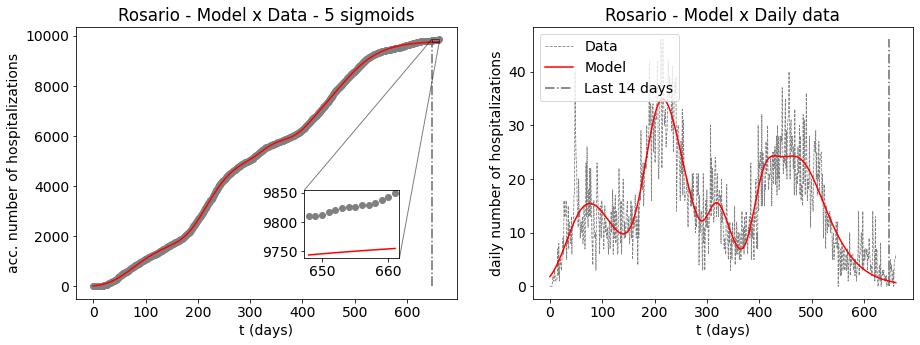

Parameters: [[1948.4810445238204, 76.32697872346891, 44.24418932125283, 0.10000000000002086], [3341.7579335398245, 217.36587165105263, 33.16097417129669, 0.24421182866325875], [689.2160882402919, 323.8231553153267, 21.489286236248045, 0.10000000000000338], [1736.497286425565, 417.651212578082, 28.4408789687567, 0.10000000000000003], [2067.9440499620464, 489.57086993780746, 40.121579321281395, 0.10000000000001437]]


<Figure size 432x288 with 0 Axes>

In [5]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

for i in range(len(x_nw)):
    x_nw[i]
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 150
        #A0 *= 0.05
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # due to filtering delay
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    fig, axs = plt.subplots(1, 2, figsize=[15,5])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[0].set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    axs[0].scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    axs[0].vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[0].plot(y_m, label='Model', c='r')
    axs[0].set_xlabel('t (days)')
    axs[0].set_ylabel('acc. number of hospitalizations')
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = axs[0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    axs[1].set_title(f'{city_name} - Model x Daily data')
    axs[1].plot(daily_data[:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[1].plot(y_m_daily, label='Model', c='r')
    axs[1].vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[1].set_xlabel('t (days)')
    axs[1].set_ylabel('daily number of hospitalizations')
    axs[1].legend(loc=2) # upper left
    plt.savefig(f'HOSP/ACC_DAILY_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'Parameters: {sig_params}\n==================================')    

plt.tight_layout()
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()


In [6]:
acc_data

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
        ...   
784    10442.0
785    10442.0
786    10442.0
787    10442.0
788    10442.0
Name: cumulative_hospitalized_patients, Length: 789, dtype: float64

In [7]:
# Relative RMSE   (np.sqrt(MSE)/max(acc_data))
print('Relative RMSE')
# Mendoza
#print('Buenos Aires: ',round(100*np.sqrt(1485.960)/12562.0, 3),'%')
#print('Rosario: ',round(100*np.sqrt(128.739)/4656.0, 3),'%')
#print('Mendoza: ',round(100*np.sqrt(93.178)/4950.0, 3),'%')

Relative RMSE


In [8]:
A_list = []
tp_list = []
delta_list = []
nu_list = []
for i, par_sig_i in zip(range(len(sig_params)), sig_params):
    print(f'Parameters Sigmoid {i}: {par_sig_i}')
    [A, tp, delta, nu] = par_sig_i
    A_list.append(round(A))
    tp_list.append(round(tp))
    delta_list.append(round(delta, 1))
    nu_list.append(round(nu, 3))

data_dict = {
    r'Sigmoid Number':range(len(sig_params)),
    r'A': A_list,
    r'$t_p$': tp_list,
    r'$\nu$': nu_list,
    r'$\delta$': delta_list,
}


Parameters Sigmoid 0: [1948.4810445238204, 76.32697872346891, 44.24418932125283, 0.10000000000002086]
Parameters Sigmoid 1: [3341.7579335398245, 217.36587165105263, 33.16097417129669, 0.24421182866325875]
Parameters Sigmoid 2: [689.2160882402919, 323.8231553153267, 21.489286236248045, 0.10000000000000338]
Parameters Sigmoid 3: [1736.497286425565, 417.651212578082, 28.4408789687567, 0.10000000000000003]
Parameters Sigmoid 4: [2067.9440499620464, 489.57086993780746, 40.121579321281395, 0.10000000000001437]


In [9]:
df_params = pd.DataFrame(data_dict)
df_params.to_excel(f'Parameters_{city_name}.xlsx')

In [10]:
df_params

,Sigmoid Number,A,$t_p$,$\nu$,$\delta$
0,0,1948,76,0.100,44.2
1,1,3342,217,0.244,33.2
2,2,689,324,0.100,21.5
3,3,1736,418,0.100,28.4
4,4,2068,490,0.100,40.1


### Predictions - Daily - HOSP Figures

========= Wave nr 1 =========
From 0 to  155
Step 1
     fun: 3470.483746662757
     jac: array([-9.15527344e-05,  4.63867188e-03,  1.61743164e-03,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 151
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.7089764e+03, 8.4020490e+01, 2.5701900e+01, 1.0000000e+00])
Step 2
     fun: 1361.0962680197993
     jac: array([7.62939453e-05, 1.61743164e-03, 3.50952148e-04, 2.11926656e+03])
 message: 'Optimization terminated successfully'
    nfev: 85
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.94848104e+03, 7.63269787e+01, 4.42441893e+01, 1.00000000e-01])
========= Wave nr 2 =========
From 0 to  291
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1589.9022590929392
     jac: array([-0.00016785, -0.00054932, -0.0017395 ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([3.03909757e+03, 2.22736353e+02, 2.11454566e+01, 1.00000000e+00])
Step 2
     fun: 722.1569431809775
     jac: array([ 8.39233398e-05,  1.96838379e-03, -7.82012939e-03, -1.05491638e-01])
 message: 'Optimization terminated successfully'
    nfev: 101
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([3.34175514e+03, 2.17365889e+02, 3.31608792e+01, 2.44215073e-01])
========= Wave nr 3 =========
From 0 to  376
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 747.9400622838464
     jac: array([7.62939453e-06, 3.28063965e-04, 3.20434570e-04, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 71
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([627.31589485, 328.77126725,  12.9748221 ,   1.        ])
Step 2
     fun: 639.5490579949643
     jac: array([-4.57763672e-05,  1.17492676e-03,  1.63269043e-03,  9.60232773e+01])
 message: 'Optimization terminated successfully'
    nfev: 80
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([6.89216447e+02, 3.23822965e+02, 2.14891043e+01, 1.00000000e-01])
========= Wave nr 4 =========
From 0 to  431
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 583.9668583640341
     jac: array([-6.86645508e-05,  1.89208984e-03,  1.47247314e-03,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([1.11181583e+03, 4.11988687e+02, 1.22510373e+01, 1.00000000e+00])
Step 2
     fun: 556.1301244792128
     jac: array([ 0.00000000e+00, -1.44958496e-04, -1.98364258e-04,  1.80960388e+01])
 message: 'Optimization terminated successfully'
    nfev: 178
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([1.73655099e+03, 4.17652141e+02, 2.84415974e+01, 1.00000000e-01])


IndexError: index 3 is out of bounds for axis 0 with size 3

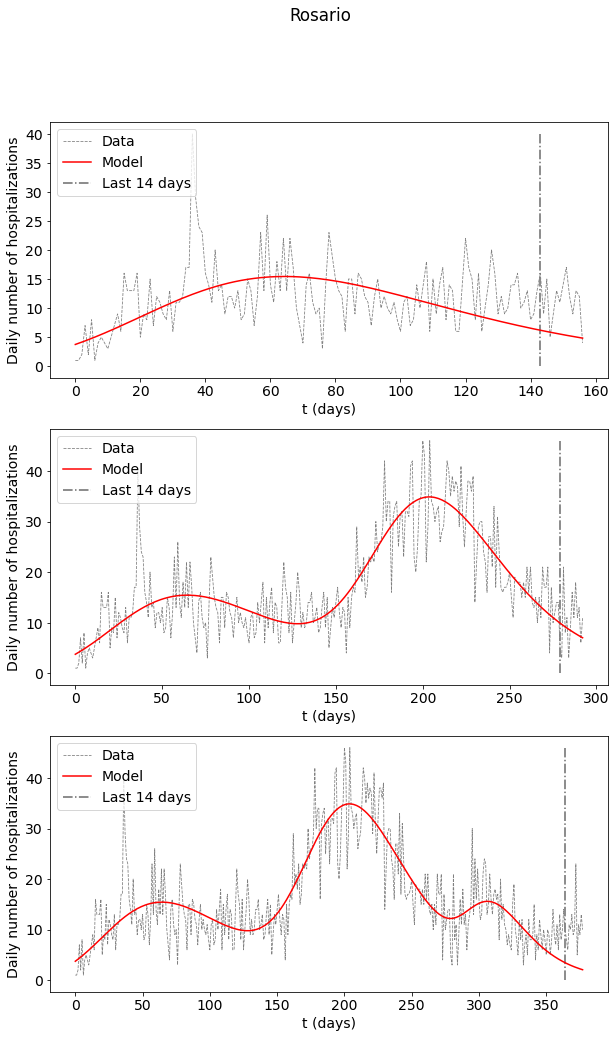

In [11]:
# Predictions for the first three waves
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(3, 1, figsize=(10,16))
#fig.suptitle(f'{city_name} - Model x Daily number of hospitalizations')
fig.suptitle(f'{city_name}')
for i in range(len(x_nw)):
    x_nw[i]
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # due to filtering delay
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    if (city_name == 'Buenos Aires'):
        shift_val = 21 # Buenos Aires
    if (city_name == 'Mendoza'):
        shift_val = 7 # Mendoza
    if (city_name == 'Rosario'):
        shift_val = 12 # Rosario - Hosp
    if (city_name == 'Córdoba'):
        shift_val = 8 # Córdoba

    axs[i].plot(daily_data[shift_val:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i].plot(y_m_daily[shift_val:], label='Model', c='r')
    axs[i].vlines(n_days - 7*n_weeks_pred - shift_val, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i].set_xlabel('t (days)')
    axs[i].set_ylabel('Daily number of hospitalizations')
    axs[i].legend(loc=2) # upper left

    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
plt.savefig(f'HOSP/{city_name}', facecolor='white', dpi=100)
plt.show()